<a href="https://colab.research.google.com/github/adib0073/AiTutorials/blob/main/ComputerVision/Object_Detection_with_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Object detection is a computer vision task that has crucial applications such as remote sensing, traffic monitoring, and various medical applications. For example, object detection may be used at a traffic crossing to collect data about the number of vehicles travelling in the different directions. This data can then be used to take steps to optimize the flow of traffic.

Various models such as YOLO, SSD, and other CNN based models have been used to address the object detection task. But recently, as described in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) by Alexey Dosovitskiy et al., Vision Transformers (ViT) have been used in CV tasks.

We will go one step ahead and implement a ViT model for the object detection task. The object detection task takes an image as an input and requires you to calculate the coordinates of the bounding box and to classify the object inside the bounding box. Given below is the architecture of the ViT model that you have seen before.
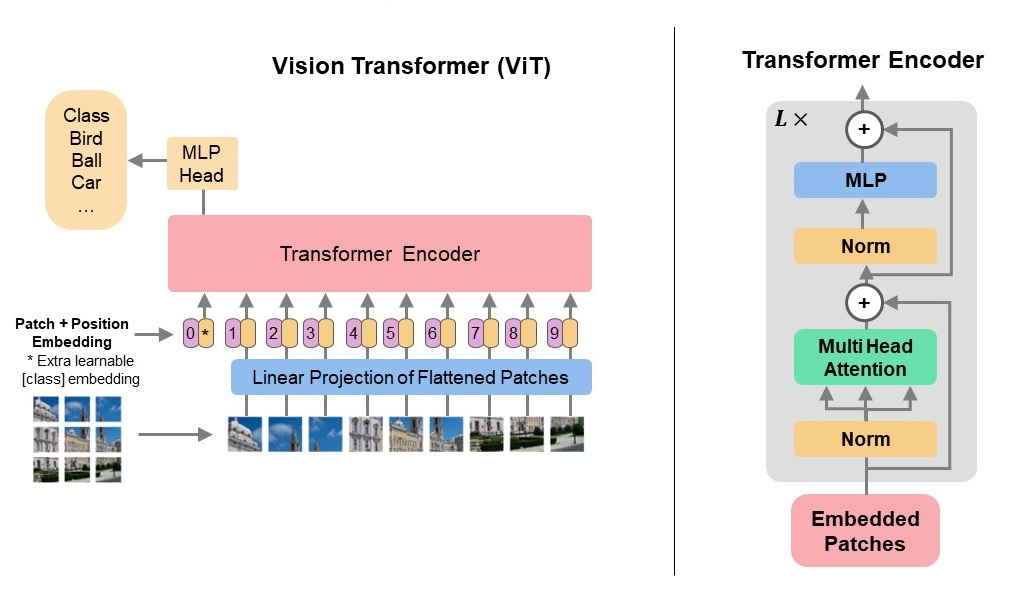

## Problem Statement
The problem statement for this Python demonstration can be summarized as follows:



> Compute, using a ViT model, the coordinates of the bounding box and the class label for an image that contains a an airplane, a face, or a motorbike.



## Data Description

In this Python Demonstration, we implement an object detection ViT and we train it on a subset of the [Caltech 101 dataset](https://data.caltech.edu/records/mzrjq-6wc02). Instead of using all the classes, we are only using the following three classes: *airplane*, *face*, and *motorbike*. The relevant data has been provided in the file named *data_object_detection.zip*. On extracting the file, you will find two folders inside:
- *images*: This folder contains subfolders for the three classes into which our data is divided. These folders contain the images that belong to the different classes in JPG format and are named as *image_0001.jpg*, *image_0002.jpg*, and so on.
- *annotations*: This folder contains subfolders for the three classes into which our data is divided. These folders contain the bounding box coordinates corresponding to the images in MAT format and are named as *annotation_0001.jpg*, *annotation_0002.jpg*, and so on.

We will explore the data set in more detail later.

This example requires TensorFlow 2.4 or higher, and
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
from which we import the `AdamW` optimizer.

TensorFlow Addons can be installed via the following command:

```
pip install -U tensorflow-addons
```

If you are using Google Colaboratory (which is the reccomended way to attempt this exercise), make sure that you have selected the GPU runtime type by going into Runtime -> Change runtime type and selecting GPU in the Hardware accelerator. You will also need to install tensorflow-addons using the code in the next cell.

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Outline

1. Setup
2. Data prepration
3. Implementing the patch creation layer
4. Implementing the patch encoding layer
5. Implementing the multi-layer perceptron
6. Building and training the ViT model
6. Evaluating the model



## Setup

In this section, we will:
- Import required libraries
- Unzip data
- Load the data into the system

This will get us ready to start shaping the data in the shape that is required to train our model.

In [ ]:
# Import 'numpy' for working with arrays
import numpy as np

# Import 'pyplot' from 'matplotlib' for visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatches

# Import 'train_test_split' for data partitioning
from sklearn.model_selection import train_test_split

# Import methods for building and training neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Check if this is required
from tensorflow.keras.optimizers import AdamW
import tensorflow_addons as tfa

# Import 'os' to load data from storage
import os

# Import scipy.io to extract annotations from the MAT files
import scipy.io

After importing the required libraries, we will load the data. If you are using Google Colab, you need to upload the file *data_object_detection.zip* into the */content/* folder. (Note that this step may take a while as the zip file contains a lot of different files.) As the raw data has been provided in the form of a zip file, we need to unzip it. We will use the *unzip* command that you have seen before.

In [ ]:
# Unzipping the data
!unzip data_object_detection.zip

Archive:  data_object_detection.zip
replace data_object_detection/annotations/airplane/annotation_0001.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Now that we have unzipped the data set, we are ready to load it into the computer's memory. At this stage, you are encouraged to explore the newly created folder *data_object_detection* and explore the folder structure and the file names.

You should see the following folder structure:

```
data_object_detection
│
└───annotations
│   │
│   └───airplane
│   │   │   annotation_0001.mat
│   │   │   annotation_0002.mat
│   │   │   ...
│   │
│   └───face
│   │   │   annotation_0001.mat
│   │   │   annotation_0002.mat
│   │   │   ...
│   │
│   └───motorbike
│   │   │   annotation_0001.mat
│   │   │   annotation_0002.mat
│   │   │   ...
│
└───images
│   │
│   └───airplane
│   │   │   image_0001.jpg
│   │   │   image_0002.jpg
│   │   │   ...
│   │
│   └───face
│   │   │   image_0001.jpg
│   │   │   image_0002.jpg
│   │   │   ...
│   │
│   └───motorbike
│   │   │   image_0001.jpg
│   │   │   image_0002.jpg
│   │   │   ...
```







Now that we have loaded the libraries and the data, we can move on to the data preparation step.

## Data Preparation

In this section, we will:
- Load the data into memory
- Create the input and the output variables
- Divide the data set into train and test sets

At the end of this section, we will be ready with the data that will be used to train the ViT model.

To load the data into the Python environment, we will first make lists that contain the complete paths for all the images and annotations.

In [ ]:
# Save the path to the folders containing the annotations and the images
path_images = "/content/data_object_detection/images/"
path_annot = "/content/data_object_detection/annotations/"

In [ ]:
# Create an empty list to store the image paths
image_paths = []

# Save the paths of individual images into the list
# Iterate over the subfolders inside the 'images' folder
for fol in os.listdir(path_images):
    
    # Save the path to the current class folder in a variable
    class_folder = os.path.join(path_images, fol)

    # Iterate over all the files in the class folder
    for fil in os.listdir(class_folder):

        # Append the complete path into image_paths
        image_paths.append(os.path.join(class_folder, fil))

We know that the object detection task outputs two kinds of information: the bounding box coordinates and the class label. The bounding box coordinates can be extracted from the annotation files, but the class label in our data set can be extracted from the name of the folder in which the annotation file is situated.

So, similar to the case of images, we will save the path of the annotation file in a list, but unlike images, we will also save the name of the folder along with it in the form of a tuple. The name of the folder in which the annotation file belongs represents the class label and we will use it later while creating the output variable.

In [ ]:
# Create an empty list to store the annotation paths
annot_info = []

# Save the paths of individual annotations into the list
# Iterate over the subfolders inside the 'annotations' folder
for fol in os.listdir(path_annot):

    # Save the path to the current class folder in a variable
    class_folder = os.path.join(path_annot, fol)

    # Iterate over all the files in the class folder
    for fil in os.listdir(class_folder):
        
        # Append the complete path into annot_paths along with the class
        annot_info.append((os.path.join(class_folder, fil), fol))

To bring the file paths into the same order so that image paths correspond the annotation paths in the two lists, we will sort them. Note that we need to sort the *annot_info* list using the first element in the tuple (the string that contains the path) as items in annot_paths are tuples can not be ordered.

In [ ]:
# Sorting image paths
image_paths = sorted(image_paths)

# Sorting the annotation information using the annotation paths
annot_info = sorted(annot_info, key = lambda x: x[0])

Now let's load the images using the *load_image()* method from *keras.utils* and store them as PIL objects in a list.

In [ ]:
# Start with an empty list
images = []

# Load images and 
for p in image_paths:
    image = keras.utils.load_img(p)
    images.append(image)

Now let's load the annotations and the class labels to create the target variable. We will take the following steps to do this:
- Start with an empty list called targets
- Load the annotations using the *loadmat()* method from *scipy.io*
- Assign one-hot encoded labels according to the class
- Scale the bounding box coordinates down to the interval [0,1]
- Save all this information in a tuple and append that into the targets list

In [ ]:
# Start with an empty list to store targets
targets = []

# Iterate over a range equal to the length of annot_info
for i in range(0, len(annot_info)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(annot_info[i][0])["box_coord"][0]

    # Save the absolute bounding box coordinates into temporary variables: (y1, y2, x1, x2)
    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    # Assign one-hot encoded label according to the class
    if annot_info[i][1] == 'airplane':
        label = [1, 0, 0]
    elif annot_info[i][1] == 'face':
        label = [0, 1, 0]
    elif annot_info[i][1] == 'motorbike':
        label = [0, 0, 1]
    
    # Access the width and height of the current image for scaling
    (w, h) = images[i].size[:2]

    # Apply relative scaling to bounding boxes, add the one-hot encoded labels and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
            label[0],
            label[1],
            label[2]
        )
    )

Now, to explore the data that we have created, let's define a function that takes in the image and the target, and returns an image in which the bounding box is drawn on top of the image and the class label is mentioned below.

In [ ]:
def draw_box_and_label(im = None, target = None):
    '''
    Draws the bounding box on top of an image
    im: An image in the PIL format
    target: A tuple of length 7 in which the first 4 items give the scaled coordinates 
        of the bounding box and the last three represent the class in a one-hot encoded vector
    '''

    plt.figure(figsize = (5, 5))
    plt.imshow(np.asarray(im))
    
    (w, h) = im.size

    top_left_x, top_left_y = int(target[0] * w), int(target[1] * h)
    bottom_right_x, bottom_right_y = int(target[2] * w), int(target[3] * h)
    rect = pltpatches.Rectangle((top_left_x, top_left_y),
                             bottom_right_x - top_left_x,
                             bottom_right_y - top_left_y,
                             facecolor = "none",
                             edgecolor = 'red',
                             linewidth = 1)
    plt.gca().add_patch(rect)

    if target[4] == 1:
        label = 'airplane'
    elif target[5] == 1:
        label = 'face'
    elif target[6] == 1:
        label = 'motorbike'
        
    plt.gca().set_xlabel(label)
    plt.xticks([])
    plt.yticks([])


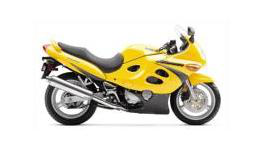

In [ ]:
images[1700]

In [ ]:
targets[1700]

(0.14942528735632185,
 0.16666666666666666,
 0.8505747126436781,
 0.8466666666666667,
 0,
 0,
 1)

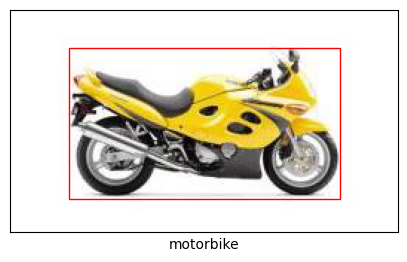

In [ ]:
draw_box_and_label(images[1700], targets[1700])

Now that we have seen what a few images and the annotations representing their bounding boxes look like, we can continue our data preparation process. We need to perform two steps now: 
- Train-test split
- Splitting the output variable

Let's start by performing the train test split.

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size = 0.2)

As we are performing two different machine learning tasks in our model, regression and classification, we need to split *y_train* and *y_test* each into two different variables such that:
- *y1_train* and *y1_test* contain the scaled down coordinates of the bounding boxes
- *y2_train* and *y2_test* contain the one-hot encoded vectors representing the class labels

In [ ]:
y1_train = np.array([np.array(t) for t in y_train]).take(indices = range(0,4), axis = 1)
y2_train = np.array([np.array(t) for t in y_train]).take(indices = range(4,7), axis = 1)
y1_test = np.array([np.array(t) for t in y_test]).take(indices = range(0,4), axis = 1)
y2_test = np.array([np.array(t) for t in y_test]).take(indices = range(4,7), axis = 1)

Let's now do a sanity check for the values of these variables.

In [ ]:
y2_train[0]

array([0., 1., 0.])

In [ ]:
y1_train[0]

array([0.13972056, 0.15407855, 0.55289421, 0.88821752])

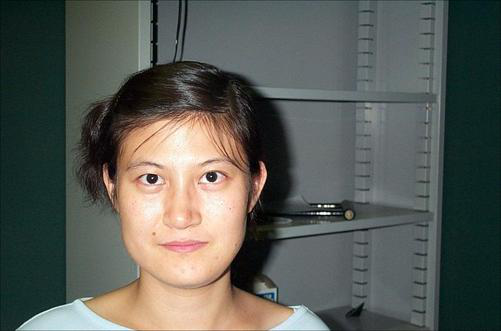

In [ ]:
X_train[0]

As you can see *y2_train[0]* is `[1., 0., 0.]` which corresponds to the `airplane` class which matches the image given above.

Finally, we need to resize and convert images in our data sets into numpy arrays. We will resize images into squares of shape 224 pixels by 224 pixels.

In [ ]:
image_size = 224
# Resizing train images and converting images and lists into np arrays
new_X_train = []
new_X_test = []
for img_train in X_train:
    new_X_train.append(keras.utils.img_to_array(img_train.resize((image_size, image_size))))

X_train = np.asarray(new_X_train)    

for img_test in X_test:
    new_X_test.append(keras.utils.img_to_array(img_test.resize((image_size, image_size))))

# Saving X_test in a separate variable for later use
X_test_save = X_test
X_test = np.asarray(new_X_test)

Finally, let's check the shapes of all six variables that we have prepared for training.

In [ ]:
print("X_train shape: ", X_train.shape,
      "\nX_test shape: ", X_test.shape,
      "\ny1_train shape: ", y1_train.shape,
      "\ny2_train shape: ", y2_train.shape,
      "\ny1_test shape: ", y1_test.shape,
      "\ny2_test shape: ", y2_test.shape)

X_train shape:  (1626, 224, 224, 3) 
X_test shape:  (407, 224, 224, 3) 
y1_train shape:  (1626, 4) 
y2_train shape:  (1626, 3) 
y1_test shape:  (407, 4) 
y2_test shape:  (407, 3)


## Implementing the patch creation layer

In this section, we will 
- Implement a custom layer that will be used to split incoming images into patches
- Try out this custom layer and try to convert one image into patches

The *Patches()* layer will be used to convert the input image into patches in the ViT model.

In [ ]:
# Inherit from the layers.Layer class
class Patches(layers.Layer):
    
    # Define the function that will be used to initialize the layer and define its attributes
    def __init__(self, patch_size):
        super().__init__()

        # Add the main attribute to the class: patch_size
        self.patch_size = patch_size

    # As we want to save the model, we need to update the get_config() method
    # of this layer. The updated config should contain all the values that 
    # are being passed as parameters to the _init_ function.

    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim
            }
        )
        return config

    # The call() method implements the actual functionality of the layer.
    def call(self, images):
        # Save the batch_size is a variable for later reference
        batch_size = tf.shape(images)[0]

        # Use the tf.image.extract_patches() method to convert the input image
        # into patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Return patches after reshaping them 
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])


Let's consider two examples to understand the functioning of the *tf.image.extract_patches()* method.

Example #1


```
  n = 10
  # images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100
  images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]

  # We generate two outputs as follows:
  # 1. 3x3 patches with stride length 5
  # 2. Same as above, but the rate is increased to 2
  tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 5, 5, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

  # Yields:
  [[[[ 1  2  3 11 12 13 21 22 23]
     [ 6  7  8 16 17 18 26 27 28]]
    [[51 52 53 61 62 63 71 72 73]
     [56 57 58 66 67 68 76 77 78]]]]
```





```
   *  *  *  4  5  *  *  *  9 10
   *  *  * 14 15  *  *  * 19 20
   *  *  * 24 25  *  *  * 29 30
  31 32 33 34 35 36 37 38 39 40
  41 42 43 44 45 46 47 48 49 50
   *  *  * 54 55  *  *  * 59 60
   *  *  * 64 65  *  *  * 69 70
   *  *  * 74 75  *  *  * 79 80
  81 82 83 84 85 86 87 88 89 90
  91 92 93 94 95 96 97 98 99 100
```



Example #2

```
  tf.image.extract_patches(images=images,
                           sizes=[1, 3, 3, 1],
                           strides=[1, 5, 5, 1],
                           rates=[1, 2, 2, 1],
                           padding='VALID')

  # Yields:
  [[[[  1   3   5  21  23  25  41  43  45]
     [  6   8  10  26  28  30  46  48  50]]

    [[ 51  53  55  71  73  75  91  93  95]
     [ 56  58  60  76  78  80  96  98 100]]]]
```





```
   *  2  *  4  *  x  7  x  9  x
  11 12 13 14 15 16 17 18 19 20
   * 22  * 24  *  x 27  x 29  x
  31 32 33 34 35 36 37 38 39 40
   * 42  * 44  *  x 47  x 49  x
   + 52  + 54  +  o 57  o 59  o
  61 62 63 64 65 66 67 68 69 70
   + 72  + 74  +  o 77  o 79  o
  81 82 83 84 85 86 87 88 89 90
   + 92  + 94  +  o 97  o 99  o
```



Now that we have implemented the patch creation layer, we can test its function by sending an image as input and printing the different patches that it outputs.

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


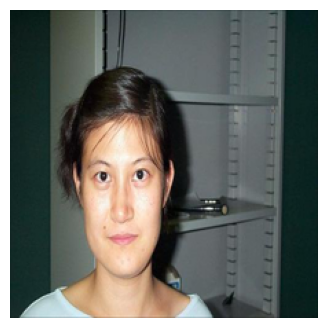

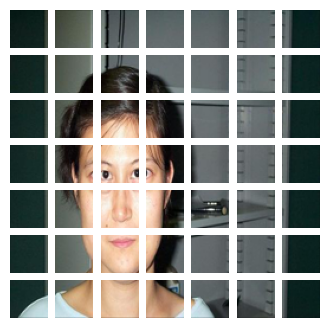

In [ ]:
# Size of the patches to be extracted from the input images
patch_size = 32 

# Print the original image that will be sent as input
plt.figure(figsize=(4, 4))
plt.imshow(X_train[0].astype("uint8"))
plt.axis("off")

# Use the Patches() layer to create patches
patches = Patches(patch_size)(tf.convert_to_tensor([X_train[0]]))

# Print relevant information
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# The square root of the total no. of patches gives the no. of patches in one direction
n = int(np.sqrt(patches.shape[1]))

# Print the patches arranged in the order in which they appear in the original image
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

We can now see the output of the *Patches()* layer. Next, let's perform all the steps required to encode the patches so that they can be sent into the transformer.

## Implement the patch encoding layer

In this section, we will implement the *PatchEncoder()* layer. It performs three tasks:
- Linearly transforms a patch by projecting it into a
vector of size *projection_dim*
- Adds a learnable position embedding, the CLS token, to the projected vector
- Adds positional embedding to the vector

In [ ]:
# Inherit from the layers.Layer class
class PatchEncoder(layers.Layer):

    # Define the function that will be used to initialize the layer and define its attributes
    def __init__(self, num_patches, projection_dim):
        '''
        num_patches: contains the number of patches which will be passed into this layer
            from the Patches() layer
        projection_dim: contains the size of the feature vector
        '''
        super().__init__()
        
        # Create class attributes from the parameters that are passed into the the _init_() function
        self.num_patches = num_patches
        self.projection_dim = projection_dim

        # Create a dense layer to perform linear transformation to create the feature vector
        self.projection = layers.Dense(units=projection_dim)

        # Create an attribute for the CLS token
        # As we want to initialize the CLS as a zeros vector, we will instantiate a 
        # zeros_initializer() object
        cls_init = tf.zeros_initializer()

        # Learnable embedding is created using the tf.Variable() class
        # Note that we have set the value of trainable to True
        self.cls_token = tf.Variable(initial_value = cls_init(shape = (1, 1, projection_dim), 
                                                              dtype = 'float32'), trainable = True)
        
        # Create a layer that creates position embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim
        )

    # As we want to save the model, we need to update the get_config() method
    # of this layer. The updated config should contain all the values that 
    # are being passed as parameters to the _init_ function.
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim
            }
        )
        return config

    # The call() method implements the actual functionality of the layer.
    def call(self, patch):
        
        # Save the batch size into a variable for later reference
        batch_size = tf.shape(patch)[0]

        # Linearly encode the patches into the feature vectors
        encoded = self.projection(patch)

        # Resize the CLS token into the requied shape and type
        cls_broadcasted = tf.cast(
            tf.broadcast_to(self.cls_token, [batch_size, 1, self.projection_dim]),
            dtype=encoded.dtype,
        )

        # Prepend the CLS token
        encoded_with_cls = tf.concat([self.cls_token, encoded], 1)
        
        # Create a range object that will be used to create position embeddings
        # Note that because the CLS token has been added to the feature vector,
        # the lenght of the position vectors is num_patches + 1
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)

        # Add the position embeddings to the vector
        encoded_with_position = encoded_with_cls + self.position_embedding(positions)

        # Return the final vector
        return encoded_with_position

## Implementing multilayer-perceptron (MLP)

In this section, we will implement the multi-layer perceptrons. These MLP heads will be added after the transformer encoder to extract information and create the output of the network.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Build the ViT model

In this section, we will:
- Build the ViT model
- Train it on the training data

The ViT model has multiple Transformer blocks. The *MultiHeadAttention()* layer is used for self-attention, applied to the sequence of image patches. The encoded patches (skip connection) and self-attention layer outputs are normalized and fed into a multilayer perceptron (MLP). The model outputs four dimensions representing the bounding box coordinates of an object.

We are using the functional method to define Keras models, instead of the *Sequential()* or the subclassing method. In this method, the preceeding layer is passed in the form of a function argument at the end of the current layer's definition. 

For example, consider a model that has three layers: *input_layer*, *layer_A* and *layer_B*. Assume that these three layers can be defined using the functions *input_layer_fn()*, *layer_A_fn()*, and *layer_B_fn()*, respectively. To put these layers together sequentially and create a keras model, you first need to define their sequence using the functional notation as follows.



```
input_layer = input_layer_fn()
layer_A = layer_A_fn()(input_layer)
layer_B = layer_B_fn()(layer_A)
```

Note that we have added an additional pair of parentheses at the end of the definition statements for *layer_A* and *layer_B*. These define the sequence in which the layers appear in the keras model. Finally, to create the keras object, we need to instantiate a *keras.Model()* object and specify the input and output as follows.



```
model = keras.Model(input = input_layer, output = output_layer)
```

Another thing to note at this point is that as we are performing two tasks with our ViT model (regression and classification), we have two different outputs. We will differentiate between the two output layers by naming them using the *name* parameter. These names will be useful later when we define different loss functions for these outputs.

Let's now define our model.


In [ ]:
# Define a function that takes in the parameters of the ViT model and returns a keras model
def create_vit_object_detector(input_shape, 
                               patch_size,
                               num_patches,
                               projection_dim,
                               num_heads,
                               transformer_units,
                               transformer_layers,
                               mlp_head_units,):
    # Create the input layer with the given input shape
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Perform layer normalization on the output of the transformer block
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
    # Use the output corresponding to the CLS token as features for the class label
    representation_lb = representation[:, 0, :]

    # Add an MLP that outputs class label
    features_lb = mlp(representation_lb, 
                      hidden_units=mlp_head_units, 
                      dropout_rate=0.3)
    
    # Name the output layer as label and use the Softmax activation for multi-class classification
    label = layers.Dense(3, 
                         activation = 'Softmax', 
                         name = "label")(features_lb)

    # Use the outpus corresponding to the patches as features for the bounding box coordinates
    representation_bb = layers.Flatten()(representation[:,1:,:])
    
    # Add an MLP that outputs bounding box coordinates
    features_bb = mlp(representation_bb, 
                      hidden_units=mlp_head_units, 
                      dropout_rate=0.3)
    
    # Name the output layer as bounding_box and use the linear activation for regression
    bounding_box = layers.Dense(4, 
                                activation = 'linear', 
                                name = "bounding_box")(features_bb)  

    # return Keras model by combining both the outputs
    return keras.Model(inputs=inputs, outputs=[bounding_box, label])

Now that we have defined the *create_vit_object_detector()* function, we can use it to create the model. Let's define the values of the parameters to this function.

In [ ]:
# Define the parameters of the function that will remain constant
input_shape = (image_size, image_size, 3)
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

Now create the model using these values.

In [ ]:
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

Now that we have built the ViT model, we can tune it using a *run_experiment()* function. This function takes in values of variables that we will use to tune the model and returns a fitted model. You can vary the values of the parameters to this function and use that to manually tune the ViT model.

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    # Initialize the optimizer
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile model
    model.compile(optimizer=optimizer, loss={"bounding_box": keras.losses.MeanSquaredError(),
                                             "label": keras.losses.CategoricalCrossentropy(from_logits=False)})

    # Fit the model
    history = model.fit(x = X_train,
                        y = {"bounding_box": y1_train, "label": y2_train},
                        batch_size = batch_size,
                        epochs = num_epochs,
                        validation_split = 0.1,
                        callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)])

    # Return the trained model
    return history

After defining the function, let's initialize the values of the parameters of this function and call the function. You are encouraged to vary these values and train the model multiple times to check how that affects the model's performance.

In [ ]:
# Define the parameters for the run_experiment() function
# Factors of 10 10^-4 and 10-2
learning_rate = 0.001
weight_decay = 0.0001
# 1, 2, 4
batch_size = 1
num_epochs = 100
history = []
num_patches = (image_size // patch_size) ** 2

In [ ]:
# Train model
history = run_experiment(vit_object_detector, 
                         learning_rate, 
                         weight_decay, 
                         batch_size, 
                         num_epochs)

Epoch 1/100
1463/1463 [==============================] - 70s 33ms/step - loss: 1.0727 - bounding_box_loss: 0.0052 - label_loss: 1.0676 - val_loss: 1.0613 - val_bounding_box_loss: 0.0048 - val_label_loss: 1.0564
Epoch 2/100
1463/1463 [==============================] - 45s 31ms/step - loss: 1.1503 - bounding_box_loss: 0.0859 - label_loss: 1.0644 - val_loss: 1.0620 - val_bounding_box_loss: 0.0049 - val_label_loss: 1.0571
Epoch 3/100
1463/1463 [==============================] - 46s 31ms/step - loss: 1.0695 - bounding_box_loss: 0.0052 - label_loss: 1.0643 - val_loss: 1.0619 - val_bounding_box_loss: 0.0047 - val_label_loss: 1.0572
Epoch 4/100
1463/1463 [==============================] - 45s 30ms/step - loss: 1.1301 - bounding_box_loss: 0.0654 - label_loss: 1.0646 - val_loss: 1.0593 - val_bounding_box_loss: 0.0047 - val_label_loss: 1.0546
Epoch 5/100
1463/1463 [==============================] - 44s 30ms/step - loss: 1.0678 - bounding_box_loss: 0.0051 - label_loss: 1.0626 - val_loss: 1.0602 - 

Now that we have built and trained our model, let's move on to evaluating it using the test data.

## Evaluate the model

In this section, we will:
- Visualize the model's performance for a few images from the test data set.
- Evaluate the model's performance over the whole test data set using mean IOU and accuracy.

Let's first define a function that calculates the IOU given the actual and the predicted bounding box coordinates.

In [ ]:
for i in range(3):
    preds = vit_object_detector.predict(X_test[i:i+1])
    print("Image no.", i, "in the test data set.\n")
    print("Actual bb coordinates: ", y1_test[i], "\n")
    print("Predicted bb coordinates: ", preds[0], "\n")
    print("Actual one-hot encoded label", y2_test[i], "\n")
    print("Predicted output of the Softmax function: ", preds[1], "\n")

1/1 [==============================] - 1s 586ms/step
Image no. 0 in the test data set.

Actual bb coordinates:  [0.1302682  0.18324607 0.87356322 0.87434555] 

Predicted bb coordinates:  [[0.17367032 0.15075105 0.83308196 0.8396508 ]] 

Actual one-hot encoded label [0. 0. 1.] 

Predicted output of the Softmax function:  [[0.3919709  0.21465851 0.39337063]] 

1/1 [==============================] - 0s 25ms/step
Image no. 1 in the test data set.

Actual bb coordinates:  [0.26530612 0.23030303 0.32142857 0.23030303] 

Predicted bb coordinates:  [[0.17367032 0.15075105 0.83308196 0.8396508 ]] 

Actual one-hot encoded label [1. 0. 0.] 

Predicted output of the Softmax function:  [[0.3919709  0.21465851 0.39337063]] 

1/1 [==============================] - 0s 24ms/step
Image no. 2 in the test data set.

Actual bb coordinates:  [0.15763547 0.18471338 0.86206897 0.85350318] 

Predicted bb coordinates:  [[0.17367032 0.15075105 0.83308196 0.8396508 ]] 

Actual one-hot encoded label [1. 0. 0.] 

P

Let's now define functions which will help us evaluate the predictions of our model better. First, we will evaluate and visualize the bounding boxes for the first three images from the test data set and their actual and predicted labels.

Let's start by defining a function that calculates the IOU given two set of bounding box coordinates. 

In [ ]:
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(0, bottom_y_intersect - top_y_intersect + 1)

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

Let's now define a new function *evaluate_bb_and_lb()* that takes in an image and draws the ground truth and the predicted bounding box on top of the image and also prints the acutal and predicted labels.

Recall that we saved created a variable *X_test_save* before resizing and converting the images to arrays. We will use that variable here to draw the images in the original shapes.

In [ ]:
def evaluate_bb_and_lb(index = None, preds = None):
    '''
    Draws the actual and predicted bounding boxes on top of an image from the 
    test data set and prints actual and predicted labels
    index: Index of the image in the test data set
    preds: Output of the network for the image at index in the test data set
    '''
    # check type if array then upscale according to w, h and simply imshow if pil then asarray and imshow

    bb_coords = preds[0][0]
    lb_output = preds[1][0]
    
    plt.figure(figsize = (8, 8))
    plt.imshow(np.asarray(X_test_save[index]))
    text = ''
    
    (w, h) = X_test_save[index].size

    top_left_x, top_left_y = int(bb_coords[0] * w), int(bb_coords[1] * h)
    bottom_right_x, bottom_right_y = int(bb_coords[2] * w), int(bb_coords[3] * h)
    rect_blue = pltpatches.Rectangle((top_left_x, top_left_y),
                                bottom_right_x - top_left_x,
                                bottom_right_y - top_left_y,
                                facecolor="none",
                                edgecolor= "blue",
                                linewidth=1,
                                label = "predicted")
    plt.gca().add_patch(rect_blue)
    print(lb_output)

    if np.argmax(lb_output) == 0:
        label_pred = 'airplane'
    elif np.argmax(lb_output) == 1:
        label_pred = 'face'
    elif np.argmax(lb_output) == 2:
        label_pred = 'motorbike'

    text += "predicted label" + ": " + label_pred

    top_left_x, top_left_y = int(y1_test[index][0] * w), int(y1_test[index][1] * h)
    bottom_right_x, bottom_right_y = int(y1_test[index][2] * w), int(y1_test[index][3] * h)
    
    rect_red = pltpatches.Rectangle((top_left_x, top_left_y),
                                bottom_right_x - top_left_x,
                                bottom_right_y - top_left_y,
                                facecolor="none",
                                edgecolor= "red",
                                linewidth=1,
                                label = "ground_truth")
    plt.gca().add_patch(rect_red)

    if np.argmax(y2_test[index]) == 0:
        label = 'airplane'
    elif np.argmax(y2_test[index]) == 1:
        label = 'face'
    elif np.argmax(y2_test[index]) == 2:
        label = 'motorbike'

    text += " | actual label" + ": " + label
        
    plt.gca().set_xlabel(text)
    plt.xticks([])
    plt.yticks([])
    plt.legend(handles = [rect_red, rect_blue])
    plt.show()
    print("\n")

1/1 [==============================] - 0s 97ms/step
Image no. 0 in the test data set.

Intersection over union:  0.9156062982632601
[0.3919709  0.21465851 0.39337063]


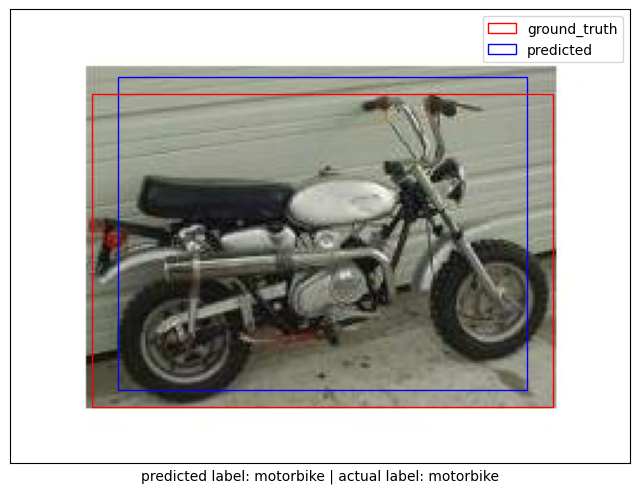



1/1 [==============================] - 0s 164ms/step
Image no. 1 in the test data set.

Intersection over union:  0.37683936352820135
[0.3919709  0.21465851 0.39337063]


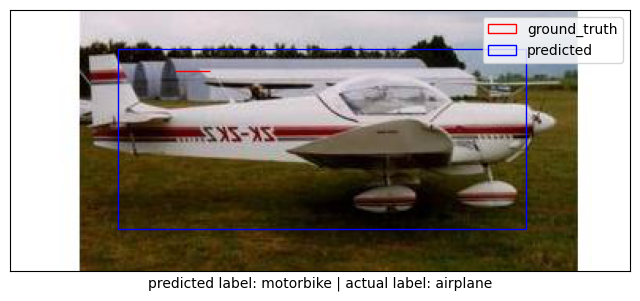



1/1 [==============================] - 0s 107ms/step
Image no. 2 in the test data set.

Intersection over union:  0.946745164186135
[0.3919709  0.21465851 0.39337063]


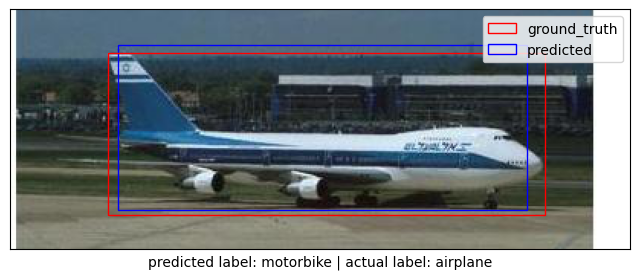



1/1 [==============================] - 0s 105ms/step
Image no. 3 in the test data set.

Intersection over union:  0.9180194411303327
[0.3919709  0.21465851 0.39337063]


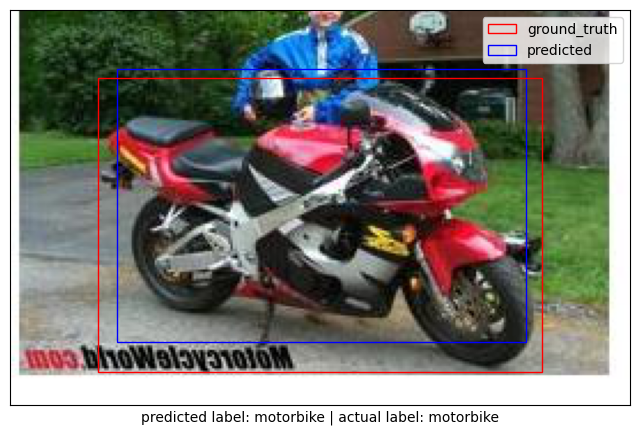



1/1 [==============================] - 0s 90ms/step
Image no. 4 in the test data set.

Intersection over union:  0.9409223140177176
[0.3919709  0.21465851 0.39337063]


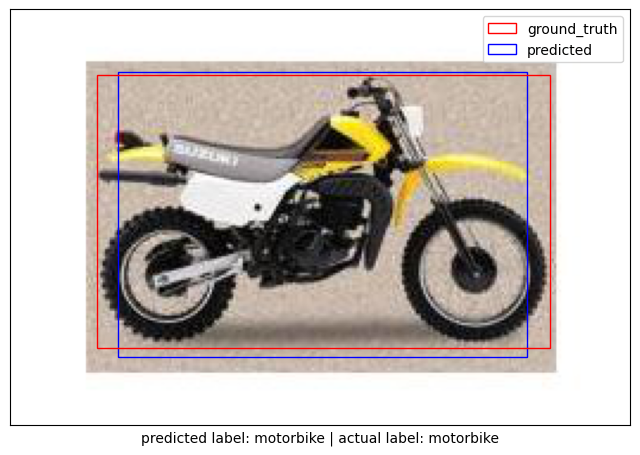

In [ ]:
for i in range(5):
    preds = vit_object_detector.predict(X_test[i:i+1])
    print("Image no.", i, "in the test data set.\n")
    iou = bounding_box_intersection_over_union(preds[0][0], y1_test[i])
    print("Intersection over union: ", iou)
    evaluate_bb_and_lb(i, preds)

Let's now calculate the mean IOU and the accuracy over the whole test data set. For that, we will define a function that returns 1 if the output label matches the ground truth label and returns 0 otherwise.

In [ ]:
def label_check(output, truth):
    if np.argmax(output) == 0:
        output_label = 'airplane'
    elif np.argmax(output) == 1:
        output_label = 'face'
    elif np.argmax(output) == 2:
        output_label = 'motorbike'
    
    if np.argmax(truth) == 0:
        truth_label = 'airplane'
    elif np.argmax(truth) == 1:
        truth_label = 'face'
    elif np.argmax(truth) == 2:
        truth_label = 'motorbike'
    
    if output_label == truth_label:
        return 1
    else:
        return 0

In [ ]:
total_iou = 0
total_match = 0
for i in range(len(X_test)):
    preds = vit_object_detector.predict(X_test[i:i+1], verbose = 0)
    iou = bounding_box_intersection_over_union(preds[0][0], y1_test[i])
    total_iou += iou
    label_match = label_check(preds[1][0], y2_test[i])
    total_match += label_match

print("mean IOU: ", total_iou/len(X_test))
print("accuracy: ", total_match/len(X_test))

mean IOU:  0.8852017485342529
accuracy:  0.40540540540540543


This example demonstrates that a pure Transformer can be trained
to predict the bounding boxes of an object in a given image,
thus extending the use of Transformers to object detection tasks.
The model can be improved further by tuning hyper-parameters and pre-training.